# Tutorial 9

## template fitting pysm data test (parametric CMB)

The `simple likelihood` is designed for pipeline's sanity check:

$$ -2\log\mathcal{L} = (\hat{X}-\bar{N}-X)^T \mathcal{M}_f^{-1} (\hat{X}-\bar{N}-X) $$

$$ X = vecp(D) $$

$$ M_f = Cov(X_f+N) $$

`H-L likelihood`:

$$ -2\log\mathcal{L} \propto vecp(D^fg[\frac{\hat{D}}{D+N}])^T \mathcal{M}_f^{-1} vecp(D^fg[\frac{\hat{D}}{D+N}]) $$

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import afra as af
from afra.tools.fg_models import syncmodel, dustmodel, syncdustmodel
from afra.tools.bg_models import cambmodel
from dynesty import utils as dyfunc
from getdist import plots, MCSamples
import warnings
warnings.filterwarnings('ignore')

NSIDE = 128
NSAMP = 10
APOSCALE = 6.
PSBIN = 20
LMIN = 35
LMAX = 200
FREQS = [95.,150.]
FWHM = [(52.8/60.)*np.pi/180.,(19./60.)*np.pi/180.,(11./60.)*np.pi/180.,(4.94/60.)*np.pi/180.]
KWARGS = {'nlive':1000}

map23f = hp.read_map('./data/pysm_s1d1_23.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map95f = hp.read_map('./data/pysm_s1d1_95.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map150f = hp.read_map('./data/pysm_s1d1_150.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map353f = hp.read_map('./data/pysm_s1d1_353.fits',field=[0,1,2],dtype=np.float32,verbose=0)
cmb_cl = hp.read_cl('./data/camb_cls.fits')
ell = np.arange(cmb_cl.shape[1])
mapcmb = np.empty((NSAMP+1,3,map23f.shape[1]),dtype=np.float32)
for i in range(NSAMP+1):
    mapcmb[i] = hp.synfast(cmb_cl,nside=NSIDE,new=True,verbose=0)

vmap23 = hp.read_map('./data/wmapvar_23.fits',field=[0,1,2],dtype=np.float32,verbose=0)
vmap95 = hp.read_map('./data/alivar_95.fits',field=[0,1,2],dtype=np.float32,verbose=0)
vmap150 = hp.read_map('./data/alivar_150.fits',field=[0,1,2],dtype=np.float32,verbose=0)
vmap353 = hp.read_map('./data/plkvar_353.fits',field=[0,1,2],dtype=np.float32,verbose=0)

nmap23 = np.random.normal(0.,1.,size=(NSAMP+1,3,vmap23.shape[1]))*np.sqrt(vmap23)
nmap95 = np.random.normal(0.,1.,size=(NSAMP+1,3,vmap95.shape[1]))*np.sqrt(vmap95)
nmap150 = np.random.normal(0.,1.,size=(NSAMP+1,3,vmap150.shape[1]))*np.sqrt(vmap150)
nmap353 = np.random.normal(0.,1.,size=(NSAMP+1,3,vmap353.shape[1]))*np.sqrt(vmap353)

map23 = hp.smoothing(mapcmb[0]+map23f,fwhm=FWHM[0],verbose=0)+nmap23[0]
map95 = hp.smoothing(mapcmb[0]+map95f,fwhm=FWHM[1],verbose=0)+nmap95[0]
map150 = hp.smoothing(mapcmb[0]+map150f,fwhm=FWHM[2],verbose=0)+nmap150[0]
map353 = hp.smoothing(mapcmb[0]+map353f,fwhm=FWHM[3],verbose=0)+nmap353[0]

fullmap = dict()
fullmap[23] = map23
fullmap[95] = map95
fullmap[150] = map150
fullmap[353] = map353

fullnoise = dict()
fullnoise[23] = nmap23[1:]
fullnoise[95] = nmap95[1:]
fullnoise[150] = nmap150[1:]
fullnoise[353] = nmap353[1:]

fullfiducial = dict()
fullfiducial[23] = mapcmb[1:]
fullfiducial[95] = mapcmb[1:]
fullfiducial[150] = mapcmb[1:]
fullfiducial[353] = mapcmb[1:]

fullbeam = dict()
fullbeam[23] = FWHM[0]
fullbeam[95] = FWHM[1]
fullbeam[150] = FWHM[2]
fullbeam[353] = FWHM[3]

tmpmap = dict()
tmpmap[23] = map23
tmpmap[353] = map353

tmpnoise = dict()
tmpnoise[23] = nmap23
tmpnoise[353] = nmap353

tmpbeam = dict()
tmpbeam[23] = FWHM[0]
tmpbeam[353] = FWHM[3]

mask = hp.read_map('./data/ali_mask.fits',dtype=bool,verbose=0)

## E mode (templated)

In [2]:
%%time

TARGET = 'E'

pipeline = af.tpfpipe(fullmap,noises=fullnoise,fiducials=fullfiducial,mask=mask,fwhms=fullbeam,
                      templates=tmpmap,template_noises=tmpnoise,template_fwhms=tmpbeam,
                      targets=TARGET,foreground=syncdustmodel,background=cambmodel)

pipeline.debug = True
inter = pipeline.preprocess(aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX)

from afra.tools.aux import oas_cov, vec_gauss
inter_signal = inter[0][0]
inter_fiducial = np.mean(inter[0][1:],axis=0)
inter_meannoise = np.mean(inter[1][1:],axis=0)
inter_cov = oas_cov(vec_gauss(inter[0][1:]))
inter_stdnoise = np.std(inter[0][1:],axis=0)

CPU times: user 51min 35s, sys: 6.65 s, total: 51min 41s
Wall time: 6min 48s


iter: 4060 | +1000 | bound: 2 | nc: 1 | ncall: 37989 | eff(%): 13.320 | loglstar:   -inf < -6.426 <    inf | logz: -10.630 +/-  0.115 | dlogz:  0.001 >  1.009                                        

Removed no burn in
Removed no burn in
$\chi^2_{g,min}$ 0.24436536293340327
$\chi^2_{h,min}$ 0.16911137041401336
CPU times: user 1h 23min 58s, sys: 1h 11min 15s, total: 2h 35min 14s
Wall time: 21min 15s
Parser   : 116 ms


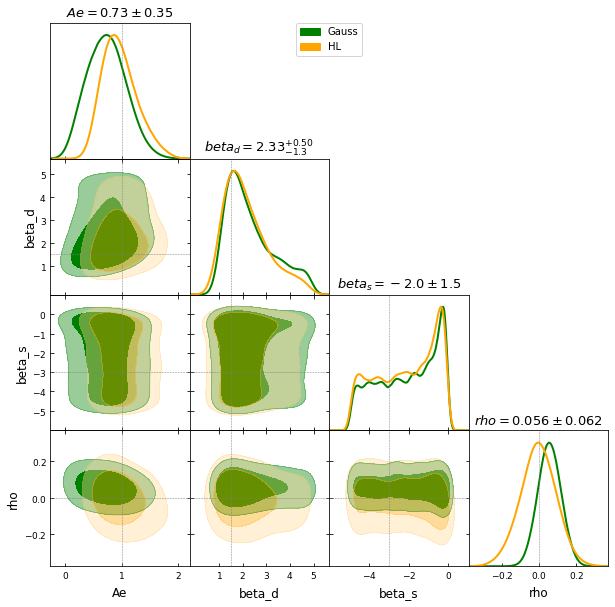

In [3]:
%%time

pipeline.likelihood='gauss'
result_g = pipeline.analyse(inter_signal,inter_fiducial,inter_meannoise,inter_cov,kwargs=KWARGS)

pipeline.likelihood='hl'
result_h = pipeline.analyse(inter_signal,inter_fiducial,inter_meannoise,inter_cov,kwargs=KWARGS)

names = pipeline.paramlist
truths = [1.,1.5,-3.,0.]

samples_g, weights_g = result_g.samples, np.exp(result_g.logwt - result_g.logz[-1])
samples1 = MCSamples(samples=samples_g,weights=weights_g,names=names,label='Gauss')

samples_h, weights_h = result_h.samples, np.exp(result_h.logwt - result_h.logz[-1])
samples2 = MCSamples(samples=samples_h,weights=weights_h,names=names,label='HL')

print (r'$\chi^2_{g,min}$',-2*max(result_g['logl'])/(len(inter_cov)-len(names)))
print (r'$\chi^2_{h,min}$',-2*max(result_h['logl'])/(len(inter_cov)-len(names)))

g = plots.get_subplot_plotter(width_inch=10)
g.settings.alpha_filled_add=0.4
g.settings.title_limit_fontsize = 15
g.triangle_plot([samples1,samples2],markers=truths,
                line_args=[{'lw':'2', 'color':'green'},{'lw':2, 'color':'orange'}],
                title_limit=1,
                contour_colors=['green','orange'],
                filled=True, contour_lws=2)

end